In [6]:
%pylab inline
from astropy.io import ascii, fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
comap = fits.open("ico.fits")
comapdata = comap[0].data[0,0]
#size (x,y) of the CO map data array
lencox, lencoy = comapdata.shape
#Filtering -- here we filter out n}ns and any value less than "thresh"
thresh = 0
mask = np.isnan(comapdata) | (comapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
comapdata[mask] = nan
#Get the world coordinates for the CO map
comapheader = comap[0].header
wc = wcs.WCS(comapheader, naxis=2)

In [3]:
atomicmap = fits.open("atomic.fits")
atomicmapdata = atomicmap[0].data
#size (x,y) of the atomic map data array
lenatomicx, lenatomicy = atomicmapdata.shape
#Filtering -- here we filter out nans and any value less than "thresh"
thresh = 0
mask = np.isnan(atomicmapdata) | (atomicmapdata<=thresh) # A Boolean (True/False) array
#Set all the above values to nan
atomicmapdata[mask] = nan
#Get the world coordinates for the CO map
atomicmapheader = atomicmap[0].header
wc2 = wcs.WCS(atomicmapheader, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [47]:
def get_ncr(data, vals):
    """
    Iterates over "vals" and return 
    NCR value or the index/array-size, 
    as Ness had mentioned.
    """
    #This again uses list comprehension
    #This iterates
    return np.array([np.where(data>=x)[0][0]/len(data) for x in vals if not np.isnan(x)])

#Sorted CO map data
comapdata_sorted = np.sort(comapdata.flatten())
#Exclude nans
comapdata_sorted_nonan = comapdata_sorted[~np.isnan(comapdata_sorted)]

#Sorted atomic map data
atomicmapdata_sorted = np.sort(atomicmapdata.flatten())
#Exclude nans
atomicmapdata_sorted_nonan = atomicmapdata_sorted[~np.isnan(atomicmapdata_sorted)]

## RSG Division

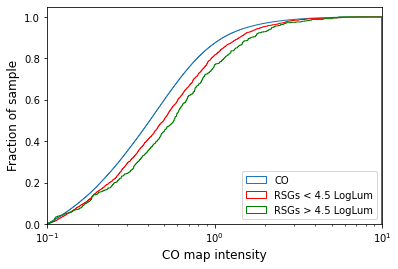

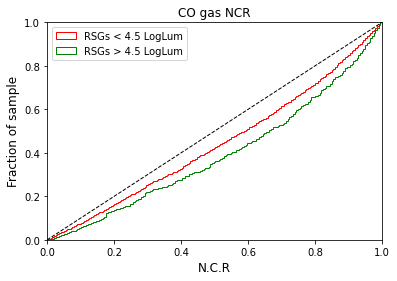

In [51]:
rsgtab = pd.read_csv('RSG.tsv', sep='\t')
rsg_lesslum = rsgtab[rsgtab['LogLum'] < 4.50]
rsg_morelum = rsgtab[rsgtab['LogLum'] > 4.50]

#Getting Coordinates
rsgcoords_lesslum = SkyCoord(rsg_lesslum["RAJ2000"], rsg_lesslum["DEJ2000"], unit=("hourangle", "deg"))
rsgcoords_morelum = SkyCoord(rsg_morelum["RAJ2000"], rsg_morelum["DEJ2000"], unit=("hourangle", "deg"))
#Now pixels
rsgpix_lesslum = np.asarray(skycoord_to_pixel(rsgcoords_lesslum, wc), dtype=int)
rsgpix_morelum = np.asarray(skycoord_to_pixel(rsgcoords_morelum, wc), dtype=int)

rsgpix_lesslum_insideco = np.array([[i,j] for i,j in rsgpix_lesslum.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsgpix_morelum_insideco = np.array([[i,j] for i,j in rsgpix_morelum.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

#Get CO intensity values for the RSG pixels
rsgco_lesslum = comapdata[rsgpix_lesslum_insideco[1], rsgpix_lesslum_insideco[0]]
rsgco_morelum = comapdata[rsgpix_morelum_insideco[1], rsgpix_morelum_insideco[0]]

#Plot 
plt.figure()
plt.hist(comapdata.flatten(), histtype="step", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="CO")
plt.hist(rsgco_lesslum, histtype="step", color="r", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="RSGs < 4.5 LogLum")
plt.hist(rsgco_morelum, histtype="step", color="g", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="RSGs > 4.5 LogLum")
plt.xlabel("CO map intensity", fontsize=12)
plt.ylabel("Fraction of sample", fontsize=12)
plt.xscale("log")
plt.xlim(0.1, 10)
plt.legend(loc=4)
plt.show()

#NCR Plot
ncr_rsgco_lesslum = get_ncr(comapdata_sorted_nonan, rsgco_lesslum)
ncr_rsgco_morelum = get_ncr(comapdata_sorted_nonan, rsgco_morelum)
plt.figure()
plt.hist(ncr_rsgco_lesslum, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs < 4.5 LogLum")
plt.hist(ncr_rsgco_morelum, histtype="step", color="g", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs > 4.5 LogLum")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

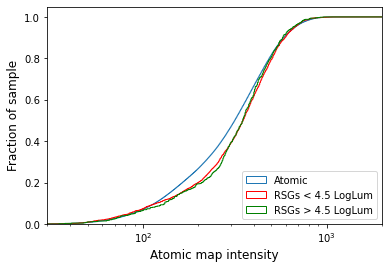

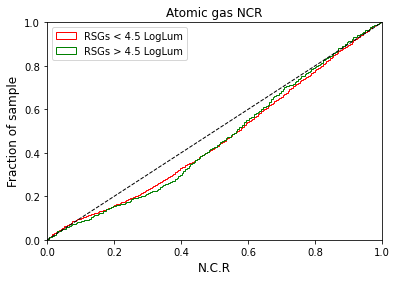

In [52]:
rsgpix_lesslum_insideatomic = np.array([[i,j] for i,j in rsgpix_lesslum.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsgpix_morelum_insideatomic = np.array([[i,j] for i,j in rsgpix_morelum.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

#Get Atomic intensity values for the RSG pixels
rsgatomic_lesslum = atomicmapdata[rsgpix_lesslum_insideatomic[1], rsgpix_lesslum_insideatomic[0]]
rsgatomic_morelum = atomicmapdata[rsgpix_morelum_insideatomic[1], rsgpix_morelum_insideatomic[0]]

#Plot 
plt.figure()
plt.hist(atomicmapdata.flatten(), histtype="step", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="Atomic")
plt.hist(rsgatomic_lesslum, histtype="step", color="r", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="RSGs < 4.5 LogLum")
plt.hist(rsgatomic_morelum, histtype="step", color="g", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="RSGs > 4.5 LogLum")
plt.xlabel("Atomic map intensity", fontsize=12)
plt.ylabel("Fraction of sample", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=4)
plt.show()

#NCR Plot
ncr_rsgatomic_lesslum = get_ncr(atomicmapdata_sorted_nonan, rsgatomic_lesslum)
ncr_rsgatomic_morelum = get_ncr(atomicmapdata_sorted_nonan, rsgatomic_morelum)
plt.figure()
plt.hist(ncr_rsgatomic_lesslum, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs < 4.5 LogLum")
plt.hist(ncr_rsgatomic_morelum, histtype="step", color="g", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs > 4.5 LogLum")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('Atomic gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

## WR Division

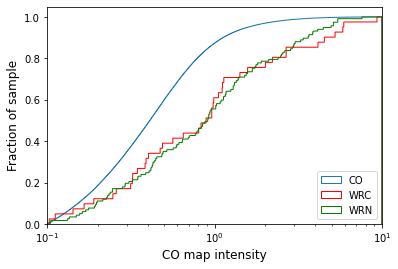

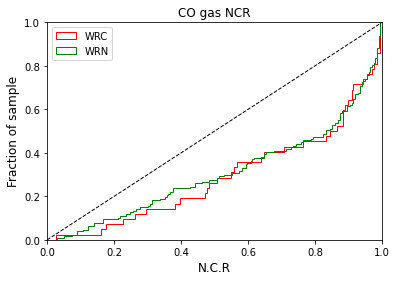

In [87]:
WRtab = pd.read_csv('wr_m33.tsv', header = 34, sep='\t')
WRCtab = WRtab[WRtab['SpT'].str.contains("WC")]
WRNtab = WRtab[WRtab['SpT'].str.contains("WN")]

#Getting Coordinates
WRCcoords = SkyCoord(WRCtab["_RA"], WRCtab["_DE"], unit=("deg"))
WRNcoords = SkyCoord(WRNtab["_RA"], WRNtab["_DE"], unit=("deg"))

#Now pixels
WRCpix = np.asarray(skycoord_to_pixel(WRCcoords, wc), dtype=int)
WRNpix = np.asarray(skycoord_to_pixel(WRNcoords, wc), dtype=int)

WRCpix_insideco = np.array([[i,j] for i,j in WRCpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
WRNpix_insideco = np.array([[i,j] for i,j in WRNpix.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

#Get CO intensity values for the WR pixels
WRCco = comapdata[WRCpix_insideco[1], WRCpix_insideco[0]]
WRNco = comapdata[WRNpix_insideco[1], WRNpix_insideco[0]]

#Plot 
plt.figure()
plt.hist(comapdata.flatten(), histtype="step", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="CO")
plt.hist(WRCco, histtype="step", color="r", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="WRC")
plt.hist(WRNco, histtype="step", color="g", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="WRN")
plt.xlabel("CO map intensity", fontsize=12)
plt.ylabel("Fraction of sample", fontsize=12)
plt.xscale("log")
plt.xlim(0.1, 10)
plt.legend(loc=4)
plt.show()

#NCR Plot
ncr_WRCco= get_ncr(comapdata_sorted_nonan, WRCco)
ncr_WRNco = get_ncr(comapdata_sorted_nonan, WRNco)
plt.figure()
plt.hist(ncr_WRCco, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRC")
plt.hist(ncr_WRNco, histtype="step", color="g", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRN")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()


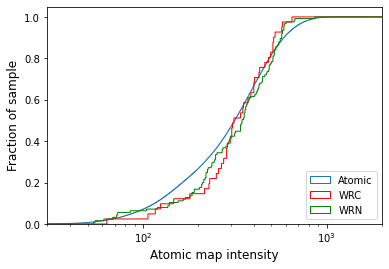

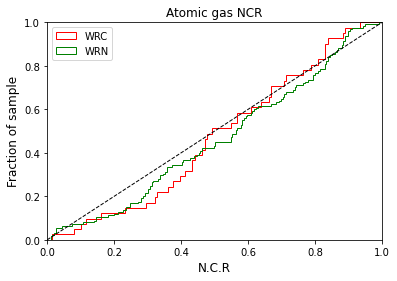

In [88]:
WRCpix_insideatomic = np.array([[i,j] for i,j in WRCpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
WRNpix_insideatomic = np.array([[i,j] for i,j in WRNpix.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

#Get Atomic intensity values for the WR pixels
WRCatomic = atomicmapdata[WRCpix_insideatomic[1], WRCpix_insideatomic[0]]
WRNatomic = atomicmapdata[WRNpix_insideatomic[1], WRNpix_insideatomic[0]]

#Plot 
plt.figure()
plt.hist(atomicmapdata.flatten(), histtype="step", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="Atomic")
plt.hist(WRCatomic, histtype="step", color="r", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="WRC")
plt.hist(WRNatomic, histtype="step", color="g", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="WRN")
plt.xlabel("Atomic map intensity", fontsize=12)
plt.ylabel("Fraction of sample", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=4)
plt.show()

#NCR Plot
ncr_WRCatomic= get_ncr(atomicmapdata_sorted_nonan, WRCatomic)
ncr_WRNatomic = get_ncr(atomicmapdata_sorted_nonan, WRNatomic)
plt.figure()
plt.hist(ncr_WRCatomic, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRC")
plt.hist(ncr_WRNatomic, histtype="step", color="g", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="WRN")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('Atomic gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

## Larger RSG Division

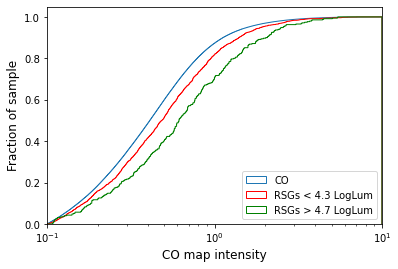

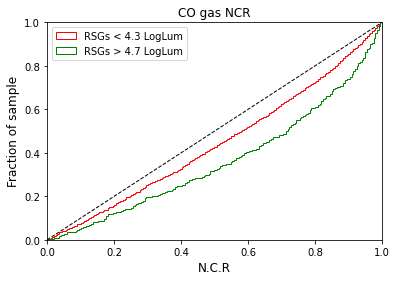

In [90]:
rsgtab = pd.read_csv('RSG.tsv', sep='\t')
rsg_lesslum2 = rsgtab[rsgtab['LogLum'] < 4.30]
rsg_morelum2 = rsgtab[rsgtab['LogLum'] > 4.70]

#Getting Coordinates
rsgcoords_lesslum2 = SkyCoord(rsg_lesslum2["RAJ2000"], rsg_lesslum2["DEJ2000"], unit=("hourangle", "deg"))
rsgcoords_morelum2 = SkyCoord(rsg_morelum2["RAJ2000"], rsg_morelum2["DEJ2000"], unit=("hourangle", "deg"))
#Now pixels
rsgpix_lesslum2 = np.asarray(skycoord_to_pixel(rsgcoords_lesslum2, wc), dtype=int)
rsgpix_morelum2 = np.asarray(skycoord_to_pixel(rsgcoords_morelum2, wc), dtype=int)

rsgpix_lesslum_insideco2 = np.array([[i,j] for i,j in rsgpix_lesslum2.T if ((0<=j<lencox) and (0<=i<lencoy))]).T
rsgpix_morelum_insideco2 = np.array([[i,j] for i,j in rsgpix_morelum2.T if ((0<=j<lencox) and (0<=i<lencoy))]).T

#Get CO intensity values for the RSG pixels
rsgco_lesslum2 = comapdata[rsgpix_lesslum_insideco2[1], rsgpix_lesslum_insideco2[0]]
rsgco_morelum2 = comapdata[rsgpix_morelum_insideco2[1], rsgpix_morelum_insideco2[0]]

#Plot 
plt.figure()
plt.hist(comapdata.flatten(), histtype="step", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="CO")
plt.hist(rsgco_lesslum2, histtype="step", color="r", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="RSGs < 4.3 LogLum")
plt.hist(rsgco_morelum2, histtype="step", color="g", density=True, cumulative=True, bins=np.logspace(-1, 1, 1000),
        label="RSGs > 4.7 LogLum")
plt.xlabel("CO map intensity", fontsize=12)
plt.ylabel("Fraction of sample", fontsize=12)
plt.xscale("log")
plt.xlim(0.1, 10)
plt.legend(loc=4)
plt.show()

#NCR Plot
ncr_rsgco_lesslum2 = get_ncr(comapdata_sorted_nonan, rsgco_lesslum2)
ncr_rsgco_morelum2 = get_ncr(comapdata_sorted_nonan, rsgco_morelum2)
plt.figure()
plt.hist(ncr_rsgco_lesslum2, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs < 4.3 LogLum")
plt.hist(ncr_rsgco_morelum2, histtype="step", color="g", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs > 4.7 LogLum")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('CO gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()

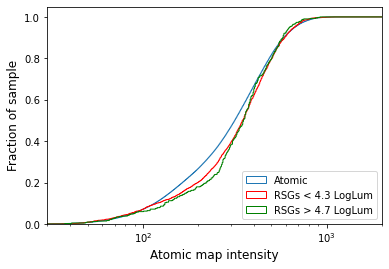

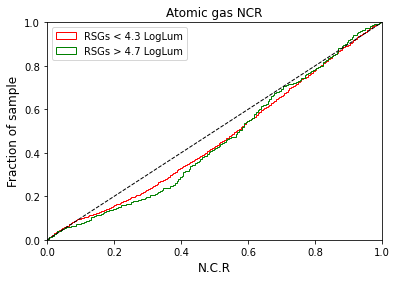

In [91]:
rsgpix_lesslum_insideatomic2 = np.array([[i,j] for i,j in rsgpix_lesslum2.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T
rsgpix_morelum_insideatomic2 = np.array([[i,j] for i,j in rsgpix_morelum2.T if ((0<=j<lenatomicx) and (0<=i<lenatomicy))]).T

#Get Atomic intensity values for the RSG pixels
rsgatomic_lesslum2 = atomicmapdata[rsgpix_lesslum_insideatomic2[1], rsgpix_lesslum_insideatomic2[0]]
rsgatomic_morelum2 = atomicmapdata[rsgpix_morelum_insideatomic2[1], rsgpix_morelum_insideatomic2[0]]

#Plot 
plt.figure()
plt.hist(atomicmapdata.flatten(), histtype="step", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="Atomic")
plt.hist(rsgatomic_lesslum2, histtype="step", color="r", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="RSGs < 4.3 LogLum")
plt.hist(rsgatomic_morelum2, histtype="step", color="g", density=True, cumulative=True, bins=np.logspace(0, 4, 1000),
        label="RSGs > 4.7 LogLum")
plt.xlabel("Atomic map intensity", fontsize=12)
plt.ylabel("Fraction of sample", fontsize=12)
plt.xscale("log")
plt.xlim(30, 2000)
plt.legend(loc=4)
plt.show()

#NCR Plot
ncr_rsgatomic_lesslum2 = get_ncr(atomicmapdata_sorted_nonan, rsgatomic_lesslum2)
ncr_rsgatomic_morelum2 = get_ncr(atomicmapdata_sorted_nonan, rsgatomic_morelum2)
plt.figure()
plt.hist(ncr_rsgatomic_lesslum2, histtype="step", color="r", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs < 4.3 LogLum")
plt.hist(ncr_rsgatomic_morelum2, histtype="step", color="g", \
         density=True, cumulative=True, bins=np.linspace(0,1,200), label="RSGs > 4.7 LogLum")
plt.ylabel("Fraction of sample", fontsize=12)
plt.plot(np.linspace(0,1,200), np.linspace(0,1,200), "k--", lw=1.0)
plt.title('Atomic gas NCR')
plt.xlabel("N.C.R", fontsize=12)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(loc=2)
plt.show()